# Тут все модули, в каждой папке одно и то же

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, CatBoostClassifier

In [2]:
df = pd.read_csv('real_estate_data.csv')
df = df.set_index('id')

df_copy = df.copy()

df.head()

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,type,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,address,furnished,heating_type,price,price_currency
id,,,,,,,,,,,,,,,,
1,Konut,Rezidans,12/10/18,1/9/19,2,30,0,20 ve üzeri,2,2+1,90.0,İstanbul/Kartal/Kordonboyu,NaN,Fancoil,3500.0,TRY
2,Konut,Daire,2/13/19,NaN,1,14,0,20 ve üzeri,20 ve üzeri,1+0,43.0,İstanbul/Kartal/Kordonboyu,NaN,Fancoil,490000.0,TRY
3,Konut,Daire,10/9/18,11/8/18,1,30,0,1,Yüksek Giriş,2+1,NaN,Tekirdağ/Çorlu/Reşadiye,NaN,Fancoil,155000.0,TRY
4,Konut,Rezidans,9/10/18,10/10/18,1,30,3,20 ve üzeri,20 ve üzeri,6+1,450.0,İstanbul/Beşiktaş/Levent,NaN,Fancoil,32500000.0,TRY
5,Konut,Rezidans,12/10/18,1/9/19,1,30,0,20 ve üzeri,2,2+1,90.0,İstanbul/Kartal/Kordonboyu,NaN,Fancoil,1450000.0,TRY


## Анализ признаков

In [3]:
# Заведём множества для категоризации признаков

drop_features = set()
categorical_features = set()
numeric_features = set()

### type

Type of property

In [4]:
col = 'type'
unique = df[col].unique()
nan_count = df[col].isna().sum()

print('Все категории:', unique)
print('Количество пропусков:', nan_count)


Все категории: ['Konut']
Количество пропусков: 0


In [5]:
# Вывод: эту колонку можно выбросить из обучения

drop_features.add(col)

### sub_type

sub group of Property Type

In [6]:
col = 'sub_type'
unique = df[col].unique()
nan_count = df[col].isna().sum()

print('Все категории:', unique)
print('Количество пропусков:', nan_count)


Все категории: ['Rezidans' 'Daire' 'Villa' 'Müstakil Ev' 'Kooperatif' 'Yazlık'
 'Komple Bina' 'Prefabrik Ev' 'Köşk / Konak / Yalı' 'Çiftlik Evi'
 'Yalı Dairesi' 'Loft']
Количество пропусков: 0


In [7]:
# Вывод - это категориальный признак

categorical_features.add(col)

### listing_type

Type of listing (sale / rent / etc.)

In [8]:
col = 'listing_type'
unique = df[col].unique()
nan_count = df[col].isna().sum()

print('Все категории:', unique)
print('Количество пропусков:', nan_count)

Все категории: [2 1 3]
Количество пропусков: 0


In [9]:
# Вывод - это категориальный признак

categorical_features.add(col)

### tom

Time on market

In [10]:
col = 'tom'
unique = df[col].unique()
nan_count = df[col].isna().sum()

print('Все категории:', unique)
print('Количество пропусков:', nan_count)

Все категории: [ 30  14  54  92  11   0  13 158  94  97 154 141  52  61 118  60 136  53
 114  34 142   7 140 117 127  47  80  42  78 161   8  64 159   1  31  48
  28 138 120   4  93  91 124  63  23 123   6 170 130  25  46  59  73   2
  99   9  69  21 134  44 121  71  76  79 139 151 126  90  51  55 156 100
 152 129   3  96  98   5  62 119  12 147  89  50 128  24 106 111  88 173
 122  83 174  19  17  68  40  15  29  67 160 110  75  37  70 131  43 145
  66  49 150 132  72  39 167  65 153 133  74 101  16  56 103 175  10  22
  33 144 149  86 168  77 108  38 146 166  45  32 104  87 177 148  26  27
  84  20 107  81  82  18 180 172 155 165 113  41  95  57  58  36  35 169
  85 143 112 163 102 116 137 125 105 162 109 157 115 179 176 171 135 164
 178]
Количество пропусков: 0


In [11]:
# Вывод - признак численный
numeric_features.add(col)

### building_age

Building age

"arası" значит "где-то между"
"ve üzeri" значит "как минимум"

In [12]:
col = 'building_age'
clean_col = 'building_age_clean'
unique = df[col].unique()
nan_count = df[col].isna().sum()

print('Все категории:', unique)
print('Количество пропусков:', nan_count)

Все категории: ['0' '3' '2' nan '1' '6-10 arası' '4' '16-20 arası' '26-30 arası'
 '40 ve üzeri' '11-15 arası' '21-25 arası' '5' '31-35 arası' '36-40 arası']
Количество пропусков: 27390


In [13]:
# Вывод - это численный признак c большим количеством пропусков и комментариев. Колонку нужно обработать.
# Для начала, разберёмся в arasi - будем брать среднее
mock_value = -1
df[clean_col] = df[col].fillna(mock_value)

def arasi_to_mean(value):
    value = str(value)
    
    if 'arası' in value:
        value = value.split(' ')[0]  # Отбросили arasi
        low, high = value.split('-') # Взяли нижнюю и верхнюю границу
        low, high = int(low), int(high)
        
        mean = (low + high) / 2
        
        return int(mean)
    
    return value

# Затем оставим только числа.
def preserve_only_digits(value):
    digits = [char for char in str(value) if char in '1234567890-.']
    value = ''.join(digits) # Сделаем из списка строку
    
    return value

df[clean_col] = df[clean_col].apply(arasi_to_mean)
df[clean_col] = df[clean_col].apply(preserve_only_digits)
df[clean_col] = df[clean_col].astype(int)

# И выберем стратегию заполнения пропусков. Варианты mean, median, mock
# mean - среднее, mode - мода распределения, median -  mock - специальное значение, которое указывает на пропуск, например, -1

# С mean и mock всё яснор
not_null = df[clean_col][df[clean_col].ne(mock_value)] # Спрячем пропуски
mean = int(not_null.mean())
age_fill_dict = dict(mean=mean, mock=mock_value)

# А для моды нужно провести анализ:

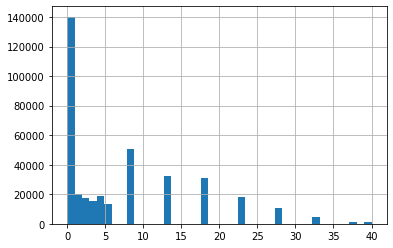

In [14]:
not_null.hist(bins=41);

In [15]:
# Вывод - мода = 0

age_fill_dict['mode'] = 0
drop_features.add(col)
numeric_features.add(clean_col)

### total_floor_count

Count of total floors in the building

"arası" значит "где-то между"
"ve üzeri" значит "как минимум"

In [16]:
col = 'total_floor_count'
clean_col = 'total_floor_count_clean'

unique = df[col].unique()
nan_count = df[col].isna().sum()

print('Все категории:', unique)
print('Количество пропусков:', nan_count)

Все категории: ['20 ve üzeri' '1' '10-20 arası' '4' '2' '3' '8' '7' '6' '5' '10' nan '9']
Количество пропусков: 28021


In [17]:
# Вывод - это численный признак c большим количеством пропусков и комментариев. Колонку нужно обработать.
# Для начала, разберёмся в arasi - будем брать среднее
mock_value = -1
df[clean_col] = df[col].fillna(mock_value)

def arasi_to_mean(value):
    value = str(value)
    
    if 'arası' in value:
        value = value.split(' ')[0]  # Отбросили arasi
        low, high = value.split('-') # Взяли нижнюю и верхнюю границу
        low, high = int(low), int(high)
        
        mean = (low + high) / 2
        
        return int(mean)
    
    return value

# Затем оставим только числа.
def preserve_only_digits(value):
    digits = [char for char in str(value) if char in '1234567890-.']
    value = ''.join(digits) # Сделаем из списка строку
    
    return value

df[clean_col] = df[clean_col].apply(arasi_to_mean)
df[clean_col] = df[clean_col].apply(preserve_only_digits)
df[clean_col] = df[clean_col].astype(int)

# И выберем стратегию заполнения пропусков. Варианты mean, median, mock
# mean - среднее, mode - мода распределения, median -  mock - специальное значение, которое указывает на пропуск, например, -1

# С mean и mock всё яснор
not_null = df[clean_col][df[clean_col].ne(mock_value)] # Спрячем пропуски
mean = int(not_null.mean())
floor_fill_dict = dict(mean=mean, mock=mock_value)

# А для моды нужно провести анализ:

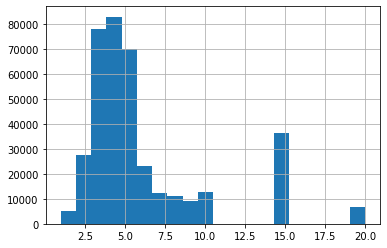

In [18]:
not_null.hist(bins=20)

In [19]:
# Вывод - модa = 4
floor_fill_dict['mode'] = 4

drop_features.add(col)
numeric_features.add(clean_col)

### room_count

In [20]:
col = 'room_count'
unique = df[col].unique()
nan_count = df[col].isna().sum()

print('Все категории:', unique)
print('Количество пропусков:', nan_count)

Все категории: ['2+1' '1+0' '6+1' '1+1' '3+1' '4+1' '2+2' '9+2' '5+2' '6+3' '6+2' '4+3'
 '9+5' '5+1' '3+2' '+' '4+2' '7+2' '9+4' '8+2' '8+3' '10+0' '8+4' '8+1'
 '7+1' '10+1' '9+3' '7+3' '10+2' '5+3' '9+1' '0+0' '10+5' '10+3' '10+4'
 '11+3' '15+5']
Количество пропусков: 0


In [21]:
# Эту колонку будем делить на две:
def get_room_count(room_count, which='total'):
    if room_count == '+':
        return 0
    
    total, living = room_count.split('+')
    
    if which == 'total':
        return int(total)
    
    return int(living)

df['total_room'] = df[col].apply(get_room_count)
df['living_room'] = df[col].apply(lambda x: get_room_count(x, 'living'))

In [22]:
drop_features.add(col)

numeric_features.add('total_room')
numeric_features.add('living_room')

### price_currency

In [23]:
col = 'price_currency'
unique = df[col].unique()
nan_count = df[col].isna().sum()

print('Все категории:', unique)
print('Количество пропусков:', nan_count)

Все категории: ['TRY' 'GBP' 'EUR' 'USD' nan]
Количество пропусков: 715


In [24]:
# Вывод - признак категориальный, пропуски придётся откинуть, остальное - сконвертировать.
df = df.dropna(subset=[col])

print('Подсчёт количества использованных в сделках валют')
df[col].value_counts()

Подсчёт количества использованных в сделках валют


TRY    400677
EUR       922
GBP       621
USD       552
Name: price_currency, dtype: int64

In [25]:
new_col = 'conversion_coeff'
new_price_col = 'conversed_price'

currency_rate = dict(TRY=1, EUR=6.49, USD=5.89, GBP=7.22)
df[new_col] = df[col].apply(currency_rate.get)
df[new_price_col] = df['price'] * df[new_col]

drop_features.add(new_col)
drop_features.add(col)
drop_features.add('price')

### heating_type

Different types of heating systems

In [26]:
col = 'heating_type'
unique = df[col].unique()
nan_count = df[col].isna().sum()

print('Все категории:', unique)
print('Количество пропусков:', nan_count)

Все категории: ['Fancoil' 'Yok' 'Kalorifer (Doğalgaz)' 'Kalorifer (Kömür)'
 'Kombi (Elektrikli)' 'Klima' 'Kombi (Doğalgaz)'
 'Merkezi Sistem (Isı Payı Ölçer)' 'Merkezi Sistem' 'Soba (Kömür)'
 'Yerden Isıtma' 'Soba (Doğalgaz)' 'Güneş Enerjisi'
 'Kalorifer (Akaryakıt)' 'Jeotermal' 'Kat Kaloriferi' nan]
Количество пропусков: 27580


In [27]:
# Категориальный признак, заполним пустоты специальными значением
mock_value = 'NODATA!'
df[col] = df[col].fillna(mock_value)

categorical_features.add(col)

### furnished

In [28]:
col = 'furnished'
unique = df[col].unique()
nan_count = df[col].isna().sum()

print('Все категории:', unique)
print('Количество пропусков:', nan_count)

Все категории: [nan]
Количество пропусков: 402772


In [29]:
# Вывод - пустая колонка, отбрасываем

drop_features.add(col)

### floor_no

In [30]:
col = 'floor_no'
clean_col = 'floor_no_clean'
unique = df[col].unique()
nan_count = df[col].isna().sum()

print('Все категории:', unique)
print('Количество пропусков:', nan_count)

Все категории: ['2' '20 ve üzeri' 'Yüksek Giriş' '10' '14' nan 'Kot 2' 'Asma Kat'
 'Bahçe katı' '11' '3' '13' '7' '16' 'Müstakil' 'Zemin Kat' '19' '4' '5'
 'En Üst Kat' '8' '15' '1' 'Giriş Katı' '9' 'Çatı Katı' '12' '17' '6'
 'Kot 4' 'Kot 1' 'Kot 3' '18' 'Teras Kat' 'Komple' 'Bodrum Kat' 1 2 3 12 4
 5 6 7 8]
Количество пропусков: 34698


In [31]:
# Зависимость цены от этажа - явно нелинейная, особенно при наличии пентхауса. Сейчас мы найдём такие записи, которые говорят об одном и том же и заменим. Всё остальное пойдёт в категории.

floor_no_replace_dict = {'Yüksek Giriş': '1', 'Zemin Kat': '0', 'Kot 1': '0', 'Giriş Katı': '0'}

df[clean_col] = df[col].apply(lambda x: floor_no_replace_dict.get(x, x))
df[clean_col] = df[clean_col].fillna('unknown')
df[clean_col] = df[clean_col].astype(str)

drop_features.add(col)
categorical_features.add(clean_col)

### address

In [32]:
col = 'address'
unique = df[col].unique()
nan_count = df[col].isna().sum()

print('Все категории:', unique)
print('Количество пропусков:', nan_count)

Все категории: ['İstanbul/Kartal/Kordonboyu' 'Tekirdağ/Çorlu/Reşadiye'
 'İstanbul/Beşiktaş/Levent' ... 'Antalya/Korkuteli/Ulucak'
 'Kastamonu/Merkez/Kırkçeşme' 'İzmir/Tire/Gökçen']
Количество пропусков: 0


In [33]:
# Вывод - определяем в категориальные без обработки
categorical_features.add(col)

## Временные фичи

In [34]:
col = 'start_date'
datetime_col = 'start_date_dt'

df[datetime_col] = pd.to_datetime(df[col])

nan_count = df[datetime_col].isna().sum()

print('Количество пропусков:', nan_count)

Количество пропусков: 0


In [35]:
col = 'end_date'
datetime_col = 'end_date_dt'

df[datetime_col] = pd.to_datetime(df[col])

nan_count = df[datetime_col].isna().sum()

print('Количество пропусков:', nan_count)

Количество пропусков: 136474


In [36]:
# Заменим все временные фичи на количество дней с самой ранней даты.
# Пропуски end_date заполним самой поздней датой
earlier = df['start_date_dt'].min()
last = df['end_date_dt'].max()

df['end_date_dt'] = df['end_date_dt'].fillna(last)

df['start_date_days'] = df['start_date_dt'].apply(lambda x: (x - earlier).days) 
df['end_date_days'] = df['end_date_dt'].apply(lambda x: (x - earlier).days) 

drop_features.add('start_date')
drop_features.add('start_date_dt')
drop_features.add('end_date')
drop_features.add('end_date_dt')

numeric_features.add('start_date_days')
numeric_features.add('end_date_days')

# Подготовка исправленного датафрейма для обучения

In [37]:
learn_df = df.copy()
learn_df.head()

,type,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,...,total_floor_count_clean,total_room,living_room,conversion_coeff,conversed_price,floor_no_clean,start_date_dt,end_date_dt,start_date_days,end_date_days
id,,,,,,,,,,,,,,,,,,,,,
1,Konut,Rezidans,12/10/18,1/9/19,2,30,0,20 ve üzeri,2,2+1,...,20,2,1,1.0,3500.0,2,2018-12-10,2019-01-09,101,131
2,Konut,Daire,2/13/19,NaN,1,14,0,20 ve üzeri,20 ve üzeri,1+0,...,20,1,0,1.0,490000.0,20 ve üzeri,2019-02-13,2019-02-27,166,180
3,Konut,Daire,10/9/18,11/8/18,1,30,0,1,Yüksek Giriş,2+1,...,1,2,1,1.0,155000.0,1,2018-10-09,2018-11-08,39,69
4,Konut,Rezidans,9/10/18,10/10/18,1,30,3,20 ve üzeri,20 ve üzeri,6+1,...,20,6,1,1.0,32500000.0,20 ve üzeri,2018-09-10,2018-10-10,10,40
5,Konut,Rezidans,12/10/18,1/9/19,1,30,0,20 ve üzeri,2,2+1,...,20,2,1,1.0,1450000.0,2,2018-12-10,2019-01-09,101,131


### Поиск выбросов

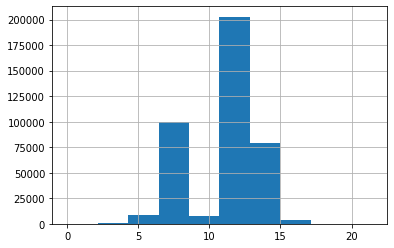

In [38]:
# Посмотрим на гистограмму цены. Распределение цен имеет логнормальную природу. Значит, возьмём логарифм и будем и в дальнейшим работать с ним:
learn_df = learn_df[learn_df.price > 0]
learn_df['logprice'] = np.log(learn_df.conversed_price)

target = learn_df.logprice
target.hist(bins=10);

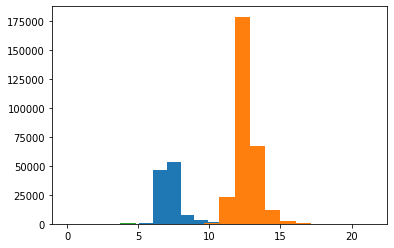

In [39]:
# Сразу же видим два пика распределение. Предположим, что на это влияет listing_type
# Разделим и посмотрим:

for ltype in learn_df.listing_type.unique():
    rows = learn_df.listing_type.eq(ltype)
    ltype_df = learn_df[rows]
    
    logprice = ltype_df.logprice
    plt.hist(logprice, bins=20)

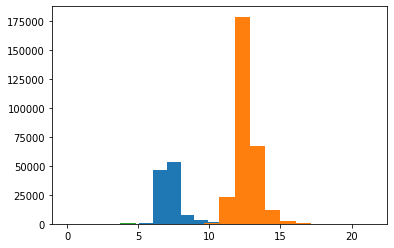

In [40]:
# Так оно и есть. Очистим по правилу трёх сигм данные для каждого из распределений
for ltype in learn_df.listing_type.unique():
    rows = learn_df.listing_type.eq(ltype)
    ltype_df = learn_df[rows]
    target = ltype_df.logprice
    
    mean, std = target.mean(), target.std()
    outliers = (abs(target - mean) > 3 * std)
    outliers = target[outliers] 
    
    learning_df = learn_df.drop(outliers.index)  # Удаляем выбросы
    logprice = ltype_df.logprice
    plt.hist(logprice, bins=20)

In [41]:
# Удалим лишние колонки:
drop_features.add('conversed_price')
learn_df = learn_df.drop(columns=drop_features)

### Задача классификации

In [42]:
def train_val_split(df, val_ratio=0.2):
    rnd = np.random.rand(df.shape[0])
    
    train_rows = rnd > val_ratio
    val_rows = ~train_rows
    
    train_df = df[train_rows]
    val_df = df[val_rows]
    
    return train_df, val_df

target = 'building_age'
class_df = learn_df.copy().drop(columns='building_age_clean')
class_df[target] = df.loc[class_df.index, target]
class_df = class_df.dropna(subset=[target])

# Заменим названия классов на порядковые числительные от 0 до N - 1, где N - количество возможных классов
target_encoder = {age: n for n, age in enumerate(class_df[target].unique())} 
class_df[target] = class_df[target].apply(target_encoder.get)

target_col = 'building_age'
train_df, val_df = train_val_split(class_df.copy())

train_x, train_y = train_df.drop(columns=[target_col]), train_df[target_col]
val_x, val_y = val_df.drop(columns=[target_col]), val_df[target_col]

In [43]:
categorical_columns = [n for n, col in enumerate(train_x.columns) if col in categorical_features]

experiment_params = dict()
experiment_params['iterations'] = 100
experiment_params['learning_rate'] = 0.1
experiment_params['depth'] = 3
experiment_params['cat_features'] = categorical_columns
experiment_params['verbose'] = 1
experiment_params['loss_function'] = 'MultiClass'
experiment_params['classes_count'] = len(val_y.unique())
# experiment_params['task_type'] = 'GPU' 

model = CatBoostClassifier(**experiment_params)

In [44]:
model.fit(train_x, train_y, eval_set=(val_x, val_y))


0:	learn: 2.4635370	test: 2.4644289	best: 2.4644289 (0)	total: 2.69s	remaining: 4m 26s
1:	learn: 2.3651614	test: 2.3670744	best: 2.3670744 (1)	total: 4.91s	remaining: 4m
2:	learn: 2.2989298	test: 2.3009540	best: 2.3009540 (2)	total: 7.2s	remaining: 3m 52s
3:	learn: 2.2501825	test: 2.2524083	best: 2.2524083 (3)	total: 9.31s	remaining: 3m 43s
4:	learn: 2.2101368	test: 2.2126070	best: 2.2126070 (4)	total: 11.5s	remaining: 3m 39s
5:	learn: 2.1804678	test: 2.1829599	best: 2.1829599 (5)	total: 13.7s	remaining: 3m 35s
6:	learn: 2.1563287	test: 2.1588874	best: 2.1588874 (6)	total: 16s	remaining: 3m 32s
7:	learn: 2.1114312	test: 2.1115108	best: 2.1115108 (7)	total: 18.3s	remaining: 3m 30s
8:	learn: 2.0734126	test: 2.0715827	best: 2.0715827 (8)	total: 20.5s	remaining: 3m 26s
9:	learn: 2.0421876	test: 2.0386702	best: 2.0386702 (9)	total: 23.1s	remaining: 3m 28s
10:	learn: 2.0171975	test: 2.0125831	best: 2.0125831 (10)	total: 25.4s	remaining: 3m 25s
11:	learn: 1.9951955	test: 1.9893360	best: 1.989

93:	learn: 1.7650835	test: 1.7458586	best: 1.7458586 (93)	total: 3m 35s	remaining: 13.8s
94:	learn: 1.7646999	test: 1.7454297	best: 1.7454297 (94)	total: 3m 38s	remaining: 11.5s
95:	learn: 1.7638972	test: 1.7446284	best: 1.7446284 (95)	total: 3m 40s	remaining: 9.2s
96:	learn: 1.7635617	test: 1.7442526	best: 1.7442526 (96)	total: 3m 43s	remaining: 6.9s
97:	learn: 1.7633449	test: 1.7440387	best: 1.7440387 (97)	total: 3m 45s	remaining: 4.6s
98:	learn: 1.7630685	test: 1.7437513	best: 1.7437513 (98)	total: 3m 47s	remaining: 2.3s
99:	learn: 1.7620417	test: 1.7427792	best: 1.7427792 (99)	total: 3m 50s	remaining: 0us

bestTest = 1.742779158
bestIteration = 99



In [45]:
pred = model.predict(val_x).ravel()
ans = val_y

(pred == ans).mean()
# как-то так

0.44263825361052955

### Задача регрессии

In [46]:
def train_val_split(df, val_ratio=0.2):
    rnd = np.random.rand(df.shape[0])
    
    train_rows = rnd > val_ratio
    val_rows = ~train_rows
    
    train_df = df[train_rows]
    val_df = df[val_rows]
    
    return train_df, val_df

target_col = 'logprice'
train_df, val_df = train_val_split(learn_df)

train_x, train_y = train_df.drop(columns=[target_col]), train_df[target_col]
val_x, val_y = val_df.drop(columns=[target_col]), val_df[target_col]

In [47]:
categorical_columns = [n for n, col in enumerate(train_x.columns) if col in categorical_features]

experiment_params = dict()
experiment_params['iterations'] = 1000
experiment_params['learning_rate'] = 0.1
experiment_params['depth'] = 8
experiment_params['cat_features'] = categorical_columns
experiment_params['verbose'] = 200

model = CatBoostRegressor(**experiment_params)

In [48]:
model.fit(train_x, train_y, eval_set=(val_x, val_y))

0:	learn: 2.3525163	test: 2.3512948	best: 2.3512948 (0)	total: 290ms	remaining: 4m 49s
200:	learn: 0.4959044	test: 0.4882052	best: 0.4882052 (200)	total: 53.1s	remaining: 3m 31s
400:	learn: 0.4739252	test: 0.4722869	best: 0.4722869 (400)	total: 1m 50s	remaining: 2m 45s
600:	learn: 0.4610603	test: 0.4645102	best: 0.4645102 (600)	total: 2m 50s	remaining: 1m 52s
800:	learn: 0.4505230	test: 0.4588314	best: 0.4588314 (800)	total: 3m 50s	remaining: 57.3s
999:	learn: 0.4424709	test: 0.4552493	best: 0.4552493 (999)	total: 4m 51s	remaining: 0us

bestTest = 0.4552492716
bestIteration = 999



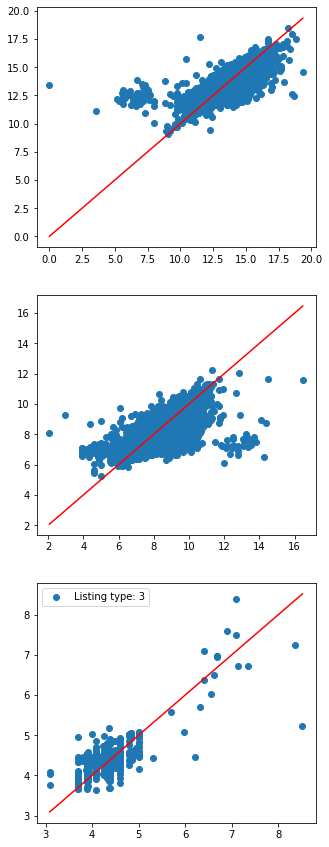

In [49]:
# как-то так, но с картинками
# по X реальная, по Y предсказали, красная - было бы идеально
pred = np.exp(model.predict(val_x)) # Мы логарифмировали цену. Делаем обратную операцию
ans = np.exp(val_y)

pred, ans = np.log(pred), np.log(ans)
f, axes = plt.subplots(3, 1, figsize=(5, 15))
for L, ax in zip(val_x.listing_type.unique(), axes.ravel()):
    targets = val_x.listing_type.eq(L)
    tans, tpred = ans[targets], pred[targets]
    
    ax.scatter(tans, tpred, label=f'Listing type: {L}')
    ax.plot([tans.min(), tans.max()], [tans.min(), tans.max()], 'r')
    
plt.legend()